In [1]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical

In [2]:
device = 'cuda' if T.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

        self.batch_size = batch_size

    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]

        return np.array(self.states),\
                np.array(self.actions),\
                np.array(self.probs),\
                np.array(self.vals),\
                np.array(self.rewards),\
                np.array(self.dones),\
                batches

    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear_memory(self):
        self.states = []
        self.probs = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.vals = []

class ActorNetwork(nn.Module):
    def __init__(self, n_actions, input_dims, alpha,
            fc1_dims=256, fc2_dims=256, chkpt_dir='tmp/ppo'):
        super(ActorNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'actor_torch_ppo')
        self.actor = nn.Sequential(
                nn.Linear(input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, n_actions),
                nn.Softmax(dim=-1)
        )

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        dist = self.actor(state)
        dist = Categorical(dist)
        
        return dist

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

class CriticNetwork(nn.Module):
    def __init__(self, input_dims, alpha, fc1_dims=256, fc2_dims=256,
            chkpt_dir='tmp/ppo'):
        super(CriticNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'critic_torch_ppo')
        self.critic = nn.Sequential(
                nn.Linear(input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, 1)
        )

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        value = self.critic(state)

        return value

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

class Agent:
    def __init__(self, n_actions, input_dims, gamma=0.99, alpha=0.0003, gae_lambda=0.95,
            policy_clip=0.2, batch_size=64, n_epochs=10):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda

        self.actor = ActorNetwork(n_actions, input_dims, alpha)
        self.critic = CriticNetwork(input_dims, alpha)
        self.memory = PPOMemory(batch_size)
       
        self.actor_loss_history = []
        self.critic_loss_history = []
        
    def remember(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state, action, probs, vals, reward, done)

    def choose_action(self, observation):
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)
        dist = self.actor(state)
        value = self.critic(state)
        action = dist.sample()

        probs = T.squeeze(dist.log_prob(action)).item()
        action = T.squeeze(action).item()
        value = T.squeeze(value).item()

        return action, probs, value

    def learn(self):
        for _ in range(self.n_epochs):
            state_arr, action_arr, old_prob_arr, vals_arr,\
            reward_arr, dones_arr, batches = \
                    self.memory.generate_batches()

            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)

            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1]*\
                            (1-int(dones_arr[k])) - values[k])
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t
            advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-8)
            advantage = T.tensor(advantage).to(self.actor.device)

            values = T.tensor(values).to(self.actor.device)
            for batch in batches:
                states = T.tensor(state_arr[batch], dtype=T.float).to(self.actor.device)
                old_probs = T.tensor(old_prob_arr[batch]).to(self.actor.device)
                actions = T.tensor(action_arr[batch]).to(self.actor.device)

                dist = self.actor(states)
                critic_value = self.critic(states)

                critic_value = T.squeeze(critic_value)

                new_probs = dist.log_prob(actions)
                prob_ratio = new_probs.exp() / old_probs.exp()
                weighted_probs = advantage[batch] * prob_ratio
                weighted_clipped_probs = T.clamp(prob_ratio, 1-self.policy_clip,
                        1+self.policy_clip)*advantage[batch]
                actor_loss = -T.min(weighted_probs, weighted_clipped_probs).mean()

                returns = advantage[batch] + values[batch]
                critic_loss = (returns-critic_value)**2
                critic_loss = critic_loss.mean()

                self.actor_loss_history.append(actor_loss.item())
                self.critic_loss_history.append(critic_loss.item())

                total_loss = actor_loss + 0.5*critic_loss
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()

        self.memory.clear_memory()

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def rewards_timestep(score_history):
    plt.figure(figsize=(12, 6))
    plt.plot(score_history, label="Episode Reward")
    smoothed_rewards = [np.mean(score_history[max(0, i-10):i+1]) for i in range(len(score_history))]
    plt.plot(smoothed_rewards, label="Smoothed Reward", color="orange", linewidth=2)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Episode Rewards")
    plt.legend()
    plt.grid()
    plt.show()

def eplen_ep(time_steps_per_episode):
    plt.plot(range(len(time_steps_per_episode)), time_steps_per_episode)
    plt.xlabel('Episodes')
    plt.ylabel('Episode Length')
    plt.title('Episode Length vs. Episodes')
    plt.show()

def ac_loss_episodes(al_hist):
    plt.plot(range(len(al_hist)), al_hist, label='Actor Loss')
    # plt.plot(range(len(cl_hist)), cl_hist, label='Critic Loss')
    plt.xlabel('Updates')
    plt.ylabel('Actor Loss')
    plt.legend()
    plt.title('Actor Loss')
    plt.show()

def cr_loss_episodes(cl_hist):
    # plt.plot(range(len(al_hist)), al_hist, label='Actor Loss')
    plt.plot(range(len(cl_hist)), cl_hist, label='Critic Loss')
    plt.xlabel('Updates')
    plt.ylabel('Critic Loss')
    plt.legend()
    plt.title('Critic Loss')
    plt.show()

In [25]:
import gym
import numpy as np

if __name__ == '__main__':
    env = gym.make('CartPole-v1', max_episode_steps=500)
    batch_size = 32
    n_epochs = 4
    alpha = 0.0003
    agent = Agent(n_actions=env.action_space.n, batch_size=batch_size, 
                    alpha=alpha, n_epochs=n_epochs, 
                    input_dims=env.observation_space.shape[0])
    n_games = 1000

    best_score = env.reward_range[0]
    score_history = []

    learn_iters = 0
    avg_score = 0
    n_steps = 0
    time_steps_per_episode = []
    for i in range(n_games):
        observation = env.reset()
        observation = observation[0]
        done = False
        score = 0
        max_steps_per_episode = 500
        step_count = 0
        while not done and step_count < max_steps_per_episode:
            action, prob, val = agent.choose_action(observation)
            observation_, reward, done, _ , _ = env.step(action)
            reward = np.clip(reward, -1, 1)
            step_count+=1
            n_steps += 1
            score += reward
            agent.remember(observation, action, prob, val, reward, done)
            observation = observation_
        agent.learn()
        score_history.append(score)
        avg_score = np.mean(score_history[-100:])
        time_steps_per_episode.append(n_steps)

        print('episode', i, 'score %.1f' % score, 'avg score %.1f' % avg_score,
                'time_steps', n_steps, 'learning_steps', learn_iters)


episode 0 score 18.0 avg score 18.0 time_steps 18 learning_steps 0
episode 1 score 30.0 avg score 24.0 time_steps 48 learning_steps 0
episode 2 score 54.0 avg score 34.0 time_steps 102 learning_steps 0
episode 3 score 45.0 avg score 36.8 time_steps 147 learning_steps 0
episode 4 score 26.0 avg score 34.6 time_steps 173 learning_steps 0
episode 5 score 25.0 avg score 33.0 time_steps 198 learning_steps 0
episode 6 score 42.0 avg score 34.3 time_steps 240 learning_steps 0
episode 7 score 32.0 avg score 34.0 time_steps 272 learning_steps 0
episode 8 score 27.0 avg score 33.2 time_steps 299 learning_steps 0
episode 9 score 30.0 avg score 32.9 time_steps 329 learning_steps 0
episode 10 score 59.0 avg score 35.3 time_steps 388 learning_steps 0
episode 11 score 33.0 avg score 35.1 time_steps 421 learning_steps 0
episode 12 score 75.0 avg score 38.2 time_steps 496 learning_steps 0
episode 13 score 59.0 avg score 39.6 time_steps 555 learning_steps 0
episode 14 score 39.0 avg score 39.6 time_step

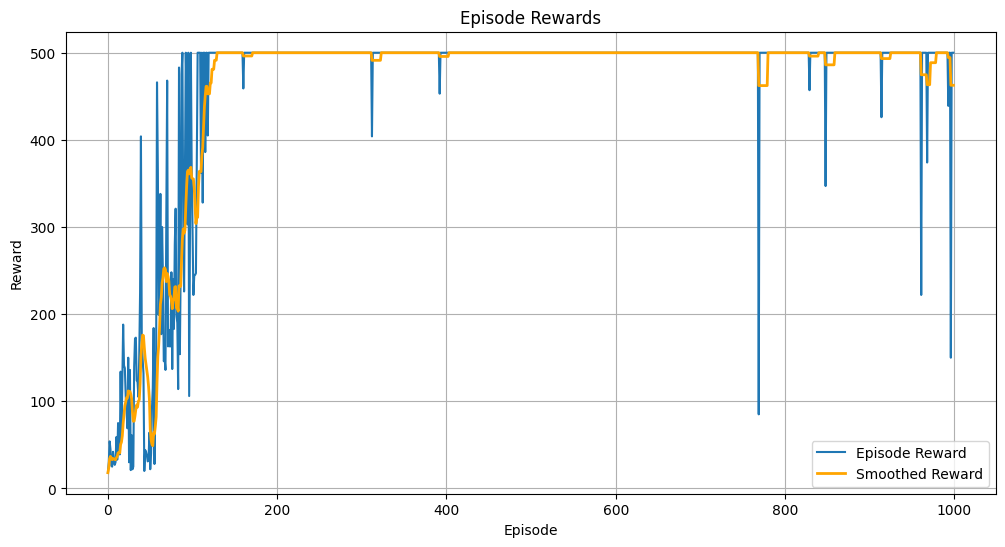

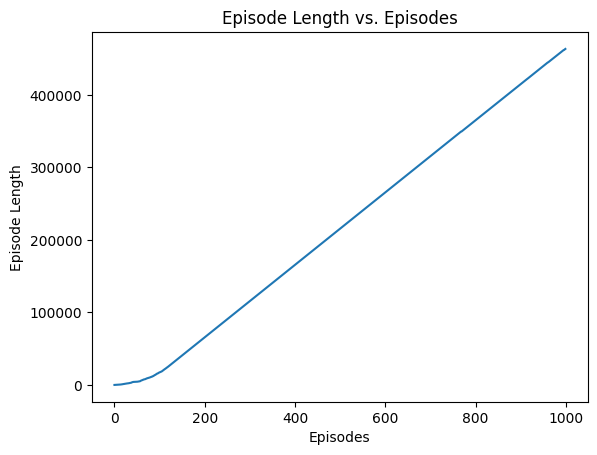

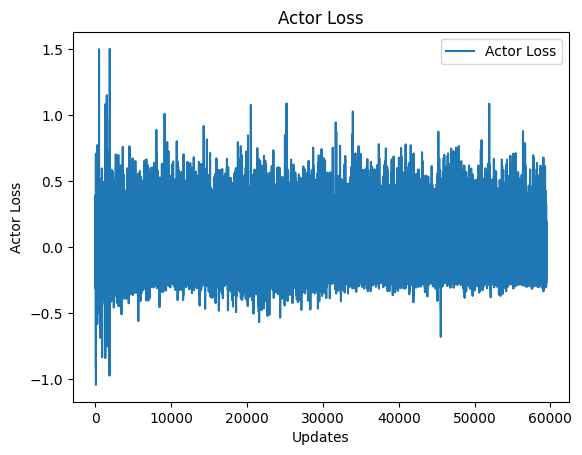

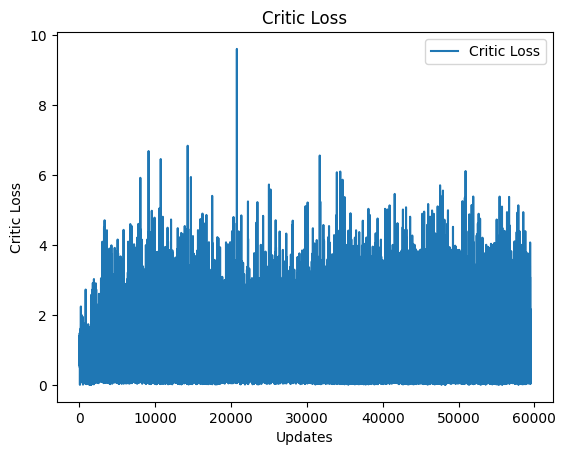

In [30]:
rewards_timestep(score_history)
eplen_ep(time_steps_per_episode)
ac_loss_episodes(agent.actor_loss_history)
cr_loss_episodes(agent.critic_loss_history)